In [2]:
import pandas as pd
import numpy as np

#NLTK library used for NLP techniques
import nltk

#string library used for removing punctuation and stopwords
import string

#re is used for Regex operations
import re

#showing how many characters in a line
pd.set_option('display.max_colwidth', 300)   

#reading the final dataset
data = pd.read_csv("/Users/aditiwalia/Downloads/Dataset - Final Sheet.tsv", sep='\t', header=None)

#columns of the data frame
data.columns = ['username', 'tweet', 'label', 'random']
#data.head()

stopwords = nltk.corpus.stopwords.words('english')

In [3]:
'''
remove_extras implemented to remove the following:
1.) The hyperlinks and URLs in the tweet
2.) RT or retweet tag
3.) HTML character codes like &amp

Parameters: a list of tokens
Returns: a string with the removed elements
'''
def remove_extras(tokens):
    text_noUrl = []
    for word in tokens:
        if "https" in word or "http" in word or word == "RT" or word == "amp":
            continue
        text_noUrl.append(word)
    return text_noUrl

'''
remove_punctAndAlphanumeric implemented to remove the punctuations and other alphanumeric characters in the text

Parameters: a string
Returns: a string with the removed elements
''' 
def remove_punctAndAlphanumeric(text):
    text_noExtra = "".join([char for char in text if char not in string.punctuation and (char in string.ascii_letters or char in char in string.whitespace)])
    return text_noExtra


'''
remove_stop implemented to remove the stopwords except "IS" because "IS" is short form for ISIS

Parameters: a list of tokens
Returns: a list of tokens with stopword tokens removed
'''
def remove_stop(tokens):
    tokens_noStop = [word for word in tokens if word not in stopwords]
    return tokens_noStop

'''
lemmatize implemented to lemmatize words/reduce each word to its basic lemma or root

Parameters: a list of tokens
Returns: a list of tokens with lemmatized words
'''
wn = nltk.WordNetLemmatizer()
def lemmatize(tokens):
    lemma_tokens = [wn.lemmatize(word) for word in tokens]
    return lemma_tokens

'''
cleanAndTokenize implemented for the cleaning, tokenizing and lemmatizing the tweets

Parameters: a string (tweets)
Returns: a list of tokens (cleaned and lemmatized)
'''
def cleanAndTokenize(text):
    cleanedText = remove_punctAndAlphanumeric(text)
    tokens = re.split('\W+',cleanedText)
    tokens_removedExtras = remove_extras(tokens)
    tokens_removedStop = remove_stop(tokens_removedExtras)
    tokens_lemmatized = lemmatize(tokens_removedStop)
    return tokens_lemmatized

In [5]:
data['preprocessed_tweet'] = data['tweet'].apply(lambda x: cleanAndTokenize(x.lower()))


In [6]:
data['tweet_len'] = data['tweet'].apply(lambda x:len(x)-x.count(" "))


In [7]:
radical_keywords = ['KUFFUR', 'IS', 'ISLAMIC STATE', '#ILOVEISIS', 'KUFFARS', 'mujahiddeen',
                    'kuffur', 'KUFFAR', 'kuffars', 'kuffar', 'kafir', 'MUJAHIDEEN', 'KUFAR', 'KAFIR',
                    'KUFR', 'mujahideen', '#IS', 'kufar', 'kufr', 'mujahid', 'JIHAD', 'jihad', 'MUJAHID',
                    'MUJAHIDDEEN', '#ISIS', 'Islamic State', '#ILoveISIS', 'ISIL', 'allah', 'Allah', 'Assad', 'assad', 'PKK',
                    'YPG', '#AleppoIsBurning', 'Aleppo', 'martydom', 'Martyrdom']

def radicalWordPresence(text):
    for key in radical_keywords:
        if key in text:
            return 1
    return 0

In [15]:
data['rad_key'] = data['tweet'].apply(lambda x:radicalWordPresence(x))


In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[['tweet', 'tweet_len', 'rad_key']], data['label'], test_size=0.2)

In [45]:
#Using Tfidf Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(analyzer=cleanAndTokenize)
tfidf_vect_fit = tfidf_vect.fit(X_train['tweet'])

tfidf_train = tfidf_vect_fit.transform(X_train['tweet'])
tfidf_test = tfidf_vect_fit.transform(X_test['tweet'])

X_train_vect = pd.concat([X_train[['tweet_len', 'rad_key']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['tweet_len', 'rad_key']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)



In [46]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import precision_recall_fscore_support as score
import time
from sklearn.metrics import plot_roc_curve


Fit Time: 3.341 / Pred Time: 0.187 -------- Precision: 0.929 / Recall: 0.667 / Accuracy: 0.94


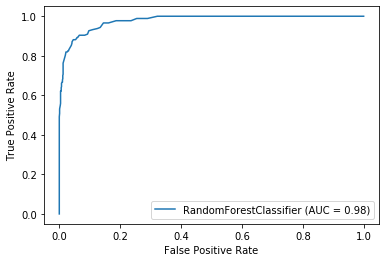

In [75]:
rf = RandomForestClassifier(n_estimators=100, max_depth=None, n_jobs=-1)

start = time.time()
rf_model = rf.fit(X_train_vect, y_train)
end = time.time()
fit_time = round((end - start),3)

start = time.time()
y_pred = rf_model.predict(X_test_vect)
end = time.time()
pred_time = round((end - start),3)

precision, recall, fscore, support = score(y_test, y_pred, pos_label=1, average='binary')
print('Fit Time: {} / Pred Time: {} -------- Precision: {} / Recall: {} / Accuracy: {}'.format(
fit_time, pred_time, round(precision,3), round(recall,3), round(((y_test==y_pred).sum() / len(y_pred)),3)
))

rf_disp = plot_roc_curve(rf_model, X_test_vect, y_test)



Fit Time: 196.307 / Pred Time: 0.188 -------- Precision: 0.909 / Recall: 0.791 / Accuracy: 0.955


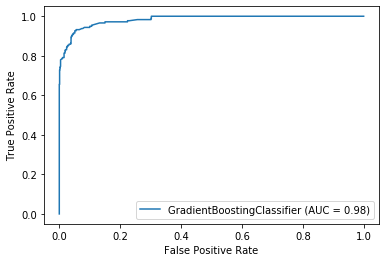

In [78]:
gb = GradientBoostingClassifier(n_estimators=150, max_depth=11)

start = time.time()
gb_model = gb.fit(X_train_vect, y_train)
end = time.time()
fit_time = round((end - start),3)

start = time.time()
y_pred = gb_model.predict(X_test_vect)
end = time.time()
pred_time = round((end - start),3)

precision, recall, fscore, support = score(y_test, y_pred, pos_label=1, average='binary')
print('Fit Time: {} / Pred Time: {} -------- Precision: {} / Recall: {} / Accuracy: {}'.format(
fit_time, pred_time, round(precision,3), round(recall,3), round(((y_test==y_pred).sum() / len(y_pred)),3)
))

gb_disp = plot_roc_curve(gb_model, X_test_vect, y_test)


Fit Time: 47.899 / Pred Time: 2.205 -------- Precision: 0.96 / Recall: 0.814 / Accuracy: 0.966


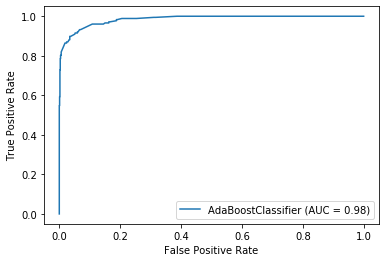

In [48]:
ab = AdaBoostClassifier(learning_rate=0.5,n_estimators=100)

start = time.time()
ab_model = ab.fit(X_train_vect, y_train)
end = time.time()
fit_time = round((end - start),3)

start = time.time()
y_pred = ab_model.predict(X_test_vect)
end = time.time()
pred_time = round((end - start),3)

precision, recall, fscore, support = score(y_test, y_pred, pos_label=1, average='binary')
print('Fit Time: {} / Pred Time: {} -------- Precision: {} / Recall: {} / Accuracy: {}'.format(
fit_time, pred_time, round(precision,3), round(recall,3), round(((y_test==y_pred).sum() / len(y_pred)),3)
))

ab_disp = plot_roc_curve(ab_model, X_test_vect, y_test)


Fit Time: 1.636 / Pred Time: 0.167 -------- Precision: 0.407 / Recall: 0.757 / Accuracy: 0.79


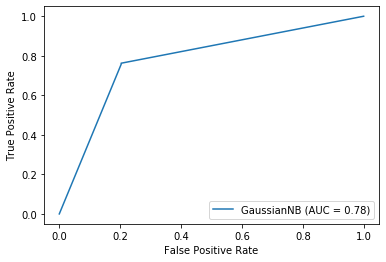

In [52]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()

start = time.time()
nb_model = nb.fit(X_train_vect, y_train)
end = time.time()
fit_time = round((end - start),3)

start = time.time()
y_pred = nb_model.predict(X_test_vect)
end = time.time()
pred_time = round((end - start),3)

precision, recall, fscore, support = score(y_test, y_pred, pos_label=1, average='binary')
print('Fit Time: {} / Pred Time: {} -------- Precision: {} / Recall: {} / Accuracy: {}'.format(
fit_time, pred_time, round(precision,3), round(recall,3), round(((y_test==y_pred).sum() / len(y_pred)),3)
))

nb_disp = plot_roc_curve(nb_model, X_test_vect, y_test)



Fit Time: 5.248 / Pred Time: 3.922 -------- Precision: 0.673 / Recall: 0.559 / Accuracy: 0.889


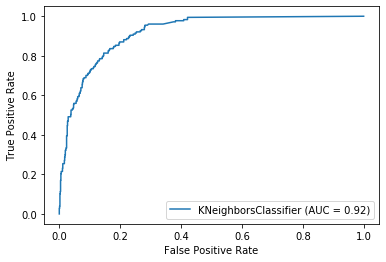

In [65]:
from sklearn.neighbors import KNeighborsClassifier

# 2. instantiate the model (with the default parameters)
knn = KNeighborsClassifier(weights='distance',metric='euclidean',n_neighbors=25)

start = time.time()
knn_model = knn.fit(X_train_vect, y_train)
end = time.time()
fit_time = round((end - start),3)

start = time.time()
y_pred = knn_model.predict(X_test_vect)
end = time.time()
pred_time = round((end - start),3)

precision, recall, fscore, support = score(y_test, y_pred, pos_label=1, average='binary')
print('Fit Time: {} / Pred Time: {} -------- Precision: {} / Recall: {} / Accuracy: {}'.format(
fit_time, pred_time, round(precision,3), round(recall,3), round(((y_test==y_pred).sum() / len(y_pred)),3)
))

knn_disp = plot_roc_curve(knn_model, X_test_vect, y_test)

y_pred1 = knn_model.predict(X_test_vect)


In [66]:
y_pred2 = knn_model.predict(X_test_vect)


Fit Time: 375.568 / Pred Time: 24.797 -------- Precision: 0.919 / Recall: 0.774 / Accuracy: 0.954


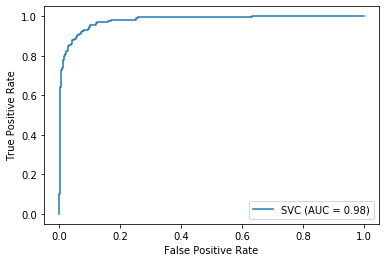

In [53]:
from sklearn import svm
sv = svm.SVC(kernel='linear',C=100)

start = time.time()
sv_model = sv.fit(X_train_vect, y_train)
end = time.time()
fit_time = round((end - start),3)

start = time.time()
y_pred = sv_model.predict(X_test_vect)
end = time.time()
pred_time = round((end - start),3)

precision, recall, fscore, support = score(y_test, y_pred, pos_label=1, average='binary')
print('Fit Time: {} / Pred Time: {} -------- Precision: {} / Recall: {} / Accuracy: {}'.format(
fit_time, pred_time, round(precision,3), round(recall,3), round(((y_test==y_pred).sum() / len(y_pred)),3)
))

sv_disp = plot_roc_curve(sv_model, X_test_vect, y_test)


In [93]:
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

In [88]:
knn.__class__.__name__

'KNeighborsClassifier'

In [94]:
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])
from sklearn.metrics import roc_curve, roc_auc_score
classifiers=[knn,ab,nb,sv,rf,gb]
y_pred_knn = knn_model.predict(X_test_vect)
fpr, tpr, _ = roc_curve(y_test,  y_pred_knn)
auc = roc_auc_score(y_test, y_pred_knn)
result_table = result_table.append({'classifiers':knn.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)


y_pred_ab=ab_model.predict(X_test_vect)
fpr, tpr, _ = roc_curve(y_test,  y_pred_ab)
auc = roc_auc_score(y_test, y_pred_ab)
result_table = result_table.append({'classifiers':ab.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

y_pred_nb=nb_model.predict(X_test_vect)
fpr, tpr, _ = roc_curve(y_test,  y_pred_nb)
auc = roc_auc_score(y_test, y_pred_nb)
result_table = result_table.append({'classifiers':nb.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)
y_pred_svm=sv_model.predict(X_test_vect)
fpr, tpr, _ = roc_curve(y_test,  y_pred_svm)
auc = roc_auc_score(y_test, y_pred_svm)
result_table = result_table.append({'classifiers':sv.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)
y_pred_rf=rf_model.predict(X_test_vect)
fpr, tpr, _ = roc_curve(y_test,  y_pred_rf)
auc = roc_auc_score(y_test, y_pred_rf)
result_table = result_table.append({'classifiers':rf.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)
y_pred_gb=gb_model.predict(X_test_vect)
fpr, tpr, _ = roc_curve(y_test,  y_pred_gb)
auc = roc_auc_score(y_test, y_pred_gb)
result_table = result_table.append({'classifiers':gb.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

result_table.set_index('classifiers', inplace=True)


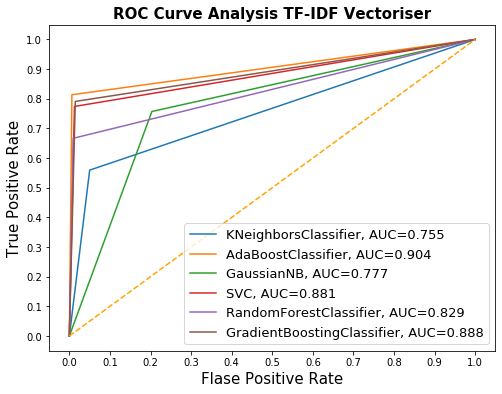

In [99]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))


for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis TF-IDF Vectoriser', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

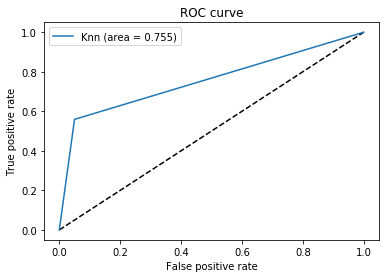

"\ny_pred_ab=ab_model.predict(X_test_vect)\nfpr, tpr, _ = roc_curve(y_test,  y_pred_ab)\nauc = roc_auc_score(y_test, y_pred_ab)\nresult_table = result_table.append({'classifiers':ab.__class__.__name__,\n                                        'fpr':fpr, \n                                        'tpr':tpr, \n                                        'auc':auc}, ignore_index=True)\n\n\nplt.figure(1)\nplt.plot([0, 1], [0, 1], 'k--')\nplt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))\nplt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))\nplt.xlabel('False positive rate')\nplt.ylabel('True positive rate')\nplt.title('ROC curve')\nplt.legend(loc='best')\nplt.show()\n# Zoom in view of the upper left corner.\nplt.figure(2)\nplt.xlim(0, 0.2)\nplt.ylim(0.8, 1)\nplt.plot([0, 1], [0, 1], 'k--')\nplt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))\nplt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))\nplt.xlabel('